In [106]:
import sys
import os
import shutil
import ftplib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import re
from contextlib import closing
import urllib.request as request
import requests
import numpy as np
import ahocorasick
from Bio import SeqIO
import hashlib
from pyteomics import mztab

In [62]:
'''
General
'''
#connect to ftp and get the list of samples
ftp_url = 'ftp.pride.ebi.ac.uk'
samples_dir = 'pride/data/proteomes/proteogenomics/cell-lines'
id_dir = 'proteomics_lfq'
triqler_file_name = 'out_triqler.tsv'
mzTab_file_name = 'out.mzTab'
output_file = 'identified_peptides.tsv'
contaminants = 'contaminants.fasta'
canonical_proteins_fasta = 'UniProtr11Dec2019+Ensembl103+GENCODE33+RefSeq29May2020.proteins.fasta'
peps_id_dir = 'peptide_ids'
checksums_file = 'checklist.chk'

#get all canonical sequences from fasta
allcan_seqs = []
parsed_file = SeqIO.parse(canonical_proteins_fasta,"fasta")
for record in parsed_file:
    allcan_seqs.append(str(record.seq))
allcan_seqs = list(set(allcan_seqs))

#get protein IDs from the contaminated database
conatm_ids = '|'.join([x.strip('>').split(' ')[0] for x in open(contaminants, 'r').readlines() if x.startswith('>')])

def rep(x):
    return re.sub('{[^}]*}', '', x.replace('(','{').replace(')', '}').replace('.',''))

In [63]:
#Get list of samples
try:
    ftp = ftplib.FTP(ftp_url, timeout=3600)
    ftp.login()
    ftplib.FTP.maxline = 100000
    ftp.cwd(samples_dir)
    samples_list = ftp.nlst()
except ftplib.all_errors:
    print('Failed to connect to the ftp site')

print("Number of Samples completed: " + str(len(samples_list)))

Number of Samples completed: 58


In [64]:
checksums = {}
try:
    lines = []
    ftp.retrlines('RETR {}'.format(checksums_file), lines.append)
    for line in lines:
        checksums[line.strip().split(' ')[-1].lstrip('./')] = line.strip().split(' ')[0]
except ftplib.error_perm as e: #the search is not done yet!
    print('Failed to get checksums file: {} in {}'.format(checksums_file, ftp.pwd(), e))

In [65]:
#extract peptides from triqler csv files

#get all peptides from the finished samples
triqler_peps_df = pd.DataFrame()
samples = []
for sample in samples_list:
    lines = []
    try:
        ftp.retrlines('RETR {}/{}/{}'.format(sample, id_dir, triqler_file_name), lines.append)
        this_peps_df = pd.DataFrame(data=[x.split('\t') for x in lines[1::]],
                          columns = lines[0].split('\t'))
        this_peps_df['Sample'] = sample
        print('Sample {}, #Peptides: {}'.format(sample, len(this_peps_df)))
    except ftplib.error_perm as e: #the search is not done yet!
        print('Sample: {}, error: {}'.format(sample, e))
        continue #to next sample
        
    triqler_peps_df = pd.concat([triqler_peps_df, this_peps_df])
    

Sample PXD003209-Sample-1, #Peptides: 5113
Sample PXD005698-Sample-1, #Peptides: 434
Sample PXD005698-Sample-2, #Peptides: 512
Sample: PXD005698-Sample-4, error: 550 Failed to open file.
Sample PXD005698-Sample-5, #Peptides: 440
Sample PXD005940-Sample-1, #Peptides: 17831
Sample PXD005940-Sample-2, #Peptides: 21963
Sample PXD005940-Sample-3, #Peptides: 15085
Sample PXD005940-Sample-4, #Peptides: 13230
Sample PXD005940-Sample-5, #Peptides: 16289
Sample PXD005940-Sample-6, #Peptides: 18161
Sample PXD005940-Sample-7, #Peptides: 17507
Sample PXD005940-Sample-8, #Peptides: 16489
Sample PXD005940-Sample-9, #Peptides: 11919
Sample PXD005942-Sample-1, #Peptides: 535
Sample PXD005942-Sample-12, #Peptides: 511
Sample PXD005942-Sample-14, #Peptides: 411
Sample PXD005942-Sample-15, #Peptides: 512
Sample PXD005942-Sample-17, #Peptides: 483
Sample PXD005942-Sample-18, #Peptides: 601
Sample PXD005942-Sample-19, #Peptides: 676
Sample PXD005942-Sample-20, #Peptides: 682
Sample PXD005942-Sample-21, #Pep

In [67]:
print('\nExtracted {} peptides from {} Samples, Avg. Peptides per Sample: {}\n'.format(len(triqler_peps_df), len(set(triqler_peps_df['Sample'])), len(triqler_peps_df)/len(set(triqler_peps_df.Sample))))


Extracted 425264 peptides from 55 Samples, Avg. Peptides per Sample: 7732.072727272727



/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='searchScore', ylabel='Density'>

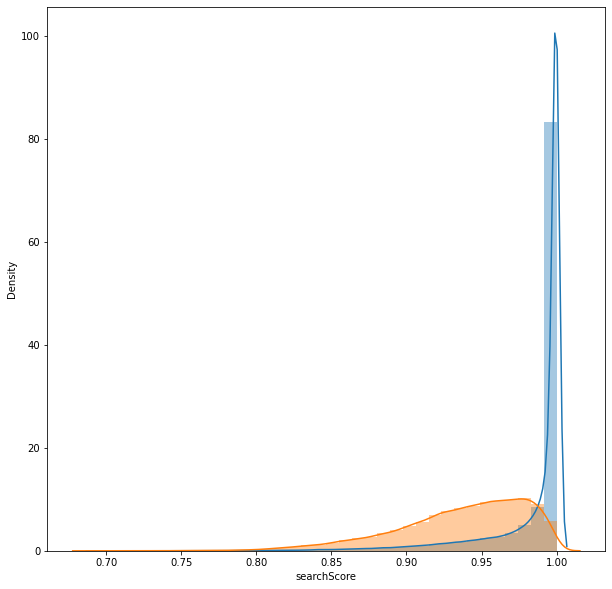

In [68]:
# This plot is for the ditribution of scores of DECOY vs TARGET 

triqler_targets = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == False]
triqler_decoys = triqler_peps_df.loc[triqler_peps_df.proteins.str.contains("DECOY") == True]

plt.figure(figsize=(10, 10))
sns.distplot(triqler_targets['searchScore'], hist=True, kde=True, 
             bins=int(180/5))
sns.distplot(triqler_decoys['searchScore'], hist=True, kde=True, 
             bins=int(180/5))

<AxesSubplot:ylabel='Sample'>

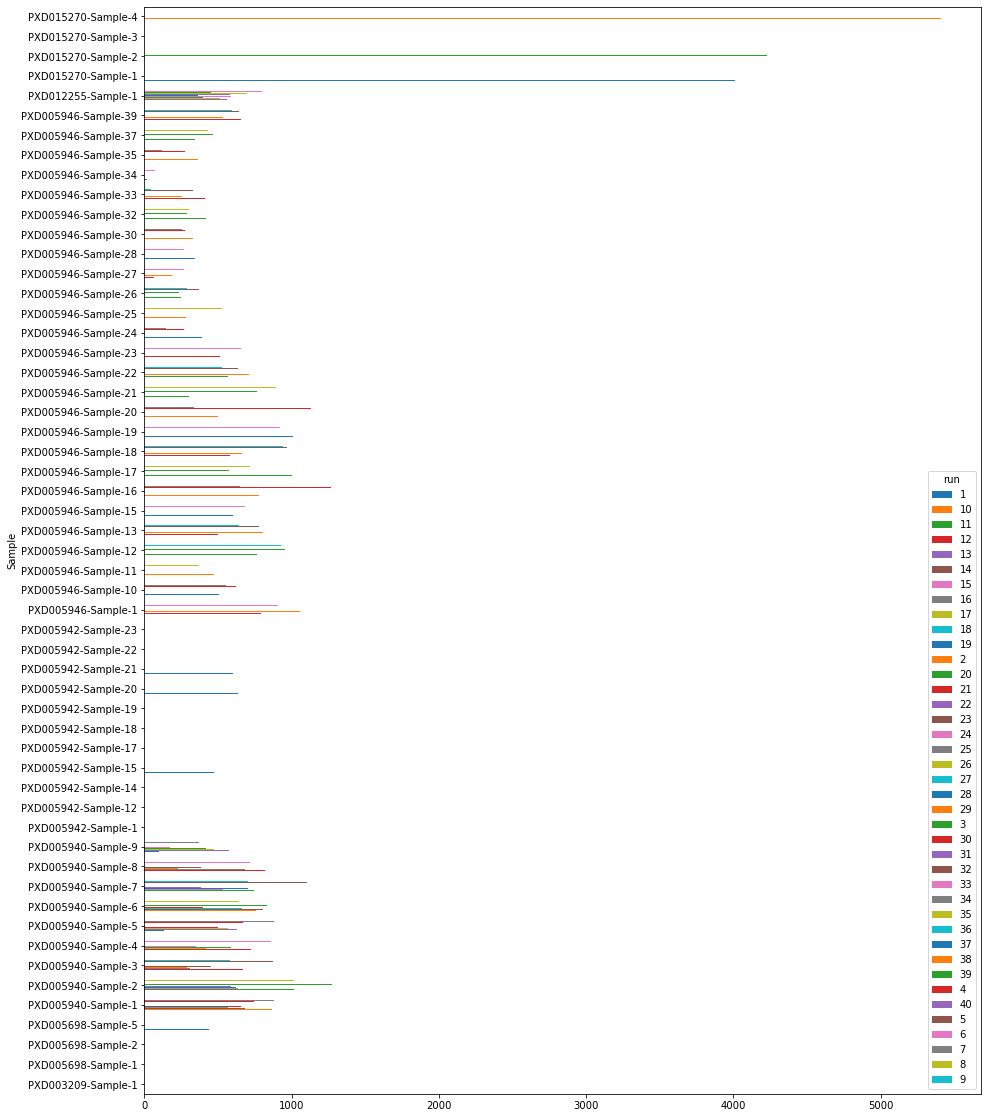

In [69]:
# Print the number of peptides per Sample and ms-run. 

plt.rcParams["figure.figsize"] = [15, 20]
triqler_targets.groupby('run').Sample.value_counts().unstack(0).plot.barh()

In [70]:
conditions = [(triqler_targets['proteins'].str.contains("ENSP") & ~triqler_targets['proteins'].str.contains(conatm_ids)),
        (~(triqler_targets['proteins'].str.contains("ENSP")|triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"altorf_|pseudo_|ncRNA_")),
        (~(triqler_targets['proteins'].str.contains(r"ENSP|altorf_|pseudo_|ncRNA_") | triqler_targets['proteins'].str.contains(conatm_ids))
         & triqler_targets['proteins'].str.contains(r"COSMIC|cbiomut")),
        (triqler_targets['proteins'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
triqler_targets['Class'] = np.select(conditions, classes)
triqler_targets['Class'].value_counts()

/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


canonical        326222
non_canonical     36530
contaminant       21444
variant             254
Name: Class, dtype: int64

<AxesSubplot:xlabel='Sample'>

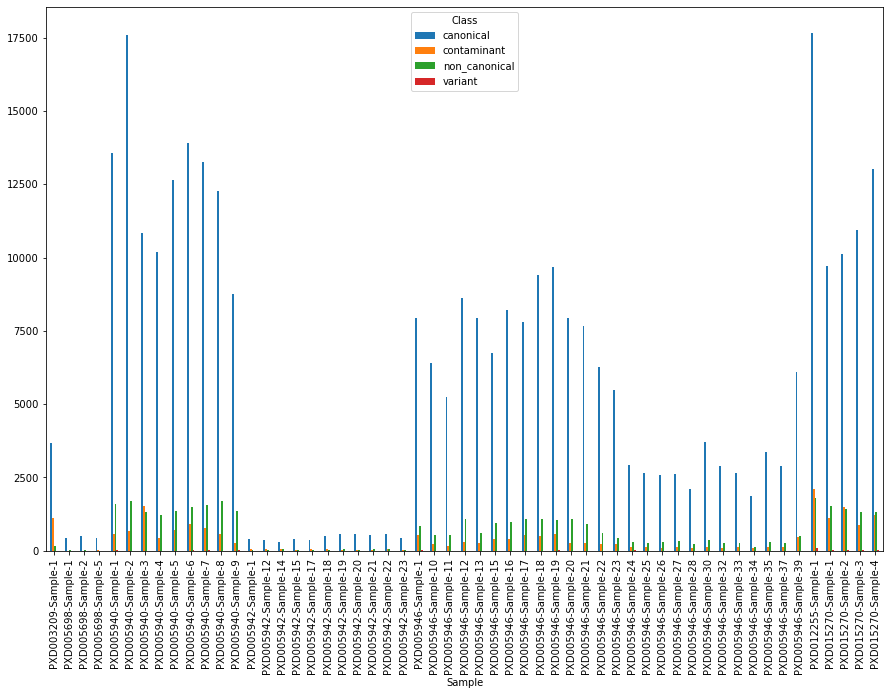

In [71]:
plt.rcParams["figure.figsize"] = [15, 10]
triqler_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [72]:
triqler_targets.to_csv('all_'+triqler_file_name, sep='\t', index=False)

In [73]:
triqler_noncan_targets = triqler_targets[triqler_targets['Class'].str.contains(r"variant|non_canonical")==True]
triqler_noncan_seqs = list(set([rep(x) for x in triqler_noncan_targets['peptide'].tolist()]))

In [74]:
#get non-canonical peptides that are found in canonical proteins
triqler_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in triqler_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        triqler_found_peps.append(found)

In [75]:
triqler_noncan_targets = triqler_noncan_targets[triqler_noncan_targets['peptide'].apply(rep).isin(triqler_found_peps)==False]

<AxesSubplot:xlabel='Sample'>

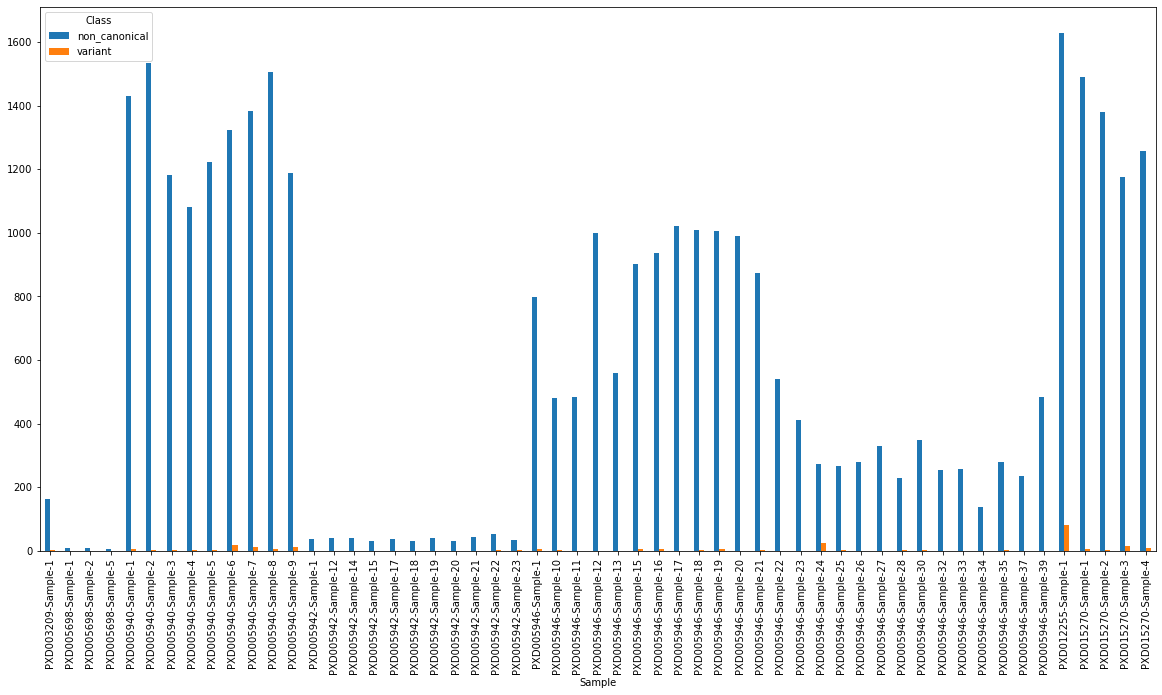

In [76]:
plt.rcParams["figure.figsize"] = [20, 10]
triqler_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [103]:
'''
                ******mzTabl processing******
'''

'\n                ******mzTabl processing******\n'

In [6]:
#Download mzTab files to a local directory to minimize running time in later runs

#create id output directory if it does not exist
if not os.path.isdir(peps_id_dir):
    os.makedirs(peps_id_dir)
download_files = []
for sample in samples_list:
    try:
        remote_file_size = ftp.size('{}/{}/{}'.format(sample, id_dir, mzTab_file_name))
    except ftplib.error_perm as e: #the search is not done yet!
        print('No file is found for sample {}, error:{}'.format(sample, e))
        continue #to next sample
    
    file_url = 'http://{}/{}/{}/{}/{}'.format(ftp_url, samples_dir, sample, id_dir, mzTab_file_name)
    outfile = '{}/{}_{}'.format(peps_id_dir, sample, mzTab_file_name)
    
    remote_checksum = checksums['{}/{}/{}'.format(sample, id_dir, mzTab_file_name)]
    local_file_size = 0
    local_checksum = ''
    try:
        local_file_size = os.path.getsize(outfile)
        local_checksum = hashlib.md5(open(outfile, 'rb').read()).hexdigest()
    except FileNotFoundError:
        pass
    if local_file_size != remote_file_size or local_checksum!=remote_checksum:
        print('Downloading:', file_url)
        with closing(request.urlopen(file_url)) as r:
            with open(outfile, 'wb') as f:
                shutil.copyfileobj(r, f)
        ftp.sendcmd('PASV')#just to avoid server timeout
    else:
        print('Already exists: ', outfile)
    download_files.append(outfile)

Already exists:  peptide_ids/PXD003209-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005698-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005698-Sample-2_out.mzTab
No file is found for sample PXD005698-Sample-4, error:550 Could not get file size.
Already exists:  peptide_ids/PXD005698-Sample-5_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-2_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-3_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-4_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-5_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-6_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-7_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-8_out.mzTab
Already exists:  peptide_ids/PXD005940-Sample-9_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-1_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-12_out.mzTab
Already exists:  peptide_ids/PXD005942-Sample-

In [45]:
#shorten accessions to save memory
def rep_acc(accessions):
    rep_accessions = []
    for acc in accessions.split(','):
        if acc.startswith('ENSP'):
            rep_accessions.append('ENSP')
        elif acc.split('_')[0] in ['altorf', 'pseudo', 'ncRNA', 'DECOY']:
            rep_accessions.append(acc.split('_')[0])
        elif acc.split(':')[0] in ['COSMIC', 'cbiomut']:
            rep_accessions.append(acc.split(':')[0])
        else:
            rep_accessions.append(acc)
    return ','.join(list(set(rep_accessions)))

In [46]:
#Extract peptides from mzTab files

#get all peptides from the finished samples
mztab_psms_df = pd.DataFrame()
for mzTab_file in glob(peps_id_dir+'/*.mzTab'):
    sample = mzTab_file.split('/')[-1].split('_')[0]
    tables = mztab.MzTab(mzTab_file)#give the mzTab file content
    psms = tables.spectrum_match_table.loc[:, ['sequence', 'accession', 'search_engine_score[1]']]
    psms['accession'] = psms['accession'].apply(rep_acc)
    psms['Sample'] = sample
    print('Sample {}, #PSMS: {}'.format(sample, len(psms)))
    mztab_psms_df = pd.concat([mztab_psms_df, psms])

Sample PXD005942-Sample-17, #PSMS: 9016
                     sequence                 accession  \
PSM_ID                                                    
0                   NMMAACDPR  altorf,ncRNA,ENSP,pseudo   
1       AAQQAASSSGQGQQAQTPTGK               altorf,ENSP   
2       AAQQAASSSGQGQQAQTPTGK               altorf,ENSP   

        search_engine_score[1]               Sample  
PSM_ID                                               
0                 2.128700e-02  PXD005942-Sample-17  
1                 8.391310e-12  PXD005942-Sample-17  
2                 4.679400e-07  PXD005942-Sample-17  
Sample PXD005946-Sample-11, #PSMS: 86133
                   sequence           accession  search_engine_score[1]  \
PSM_ID                                                                    
0       AREEEEQKEGGDGAAGDPK  altorf,ENSP,pseudo                0.001261   
1          LGGLYNPSHAHVAMGR               DECOY                0.030562   
2              AAEEEDEADPKR         altorf,ENSP      

Sample PXD005940-Sample-3, #PSMS: 140570
                     sequence                 accession  \
PSM_ID                                                    
0             SNQNGKDSKPSSTPR  altorf,ncRNA,ENSP,pseudo   
1       IANRDAEKKEGQEKEESKKDR               altorf,ENSP   
2       IANRDAEKKEGQEKEESKKDR               altorf,ENSP   

        search_engine_score[1]              Sample  
PSM_ID                                              
0                     0.002321  PXD005940-Sample-3  
1                     0.000345  PXD005940-Sample-3  
2                     0.008783  PXD005940-Sample-3  
Sample PXD005946-Sample-25, #PSMS: 67644
              sequence                  accession  search_engine_score[1]  \
PSM_ID                                                                      
0       GVDEVTIVNILTNR          altorf,ncRNA,ENSP                0.021764   
1        HLLSLSEEASDPK                     altorf                0.096662   
2          QGSGSGQSPSR  altorf,COSMIC,ENSP,Q86YZ3

Sample PXD005946-Sample-32, #PSMS: 85719
                         sequence                 accession  \
PSM_ID                                                        
0       QTSSSLSVTSVLDTLVFLLLVLIMK                     ncRNA   
1        VIHDNFGIVEGLMTTVHAITATQK  altorf,ncRNA,ENSP,pseudo   
2               FSPLTTNLINLLAENGR         altorf,ncRNA,ENSP   

        search_engine_score[1]               Sample  
PSM_ID                                               
0                     0.052949  PXD005946-Sample-32  
1                     0.013468  PXD005946-Sample-32  
2                     0.017515  PXD005946-Sample-32  
Sample PXD005946-Sample-26, #PSMS: 73304
            sequence                                accession  \
PSM_ID                                                          
0           IPLNDLFR                              altorf,ENSP   
1       ADLINNLGTIAK  altorf,cbiomut,pseudo,ncRNA,COSMIC,ENSP   
2       ADLINNLGTIAK  altorf,cbiomut,pseudo,ncRNA,COSMIC,ENSP   

      

Sample PXD005942-Sample-21, #PSMS: 8421
                    sequence           accession  search_engine_score[1]  \
PSM_ID                                                                     
0         DTENHTSHGDGRQEVTSR   altorf,ncRNA,ENSP            2.573960e-05   
1       QSLGHGQHGSGSGQSPSPSR  altorf,ENSP,Q86YZ3            5.482870e-07   
2             FAGHSEAGGGSGDR         altorf,ENSP            9.549960e-03   

                     Sample  
PSM_ID                       
0       PXD005942-Sample-21  
1       PXD005942-Sample-21  
2       PXD005942-Sample-21  
Sample PXD005946-Sample-12, #PSMS: 116656
                      sequence    accession  search_engine_score[1]  \
PSM_ID                                                                
0       QHHPPYHQQHHQGPPPGGPGGR  altorf,ENSP                0.015020   
1         HFTLLMCSADMVFSLNLWMK        ncRNA                0.040577   
2       QHHPPYHQQHHQGPPPGGPGGR  altorf,ENSP                0.009564   

                     Sample  
P

In [47]:
mztab_psms_df.columns

Index(['sequence', 'accession', 'search_engine_score[1]', 'Sample'], dtype='object')

In [48]:
print('\nExtracted {} PSMs from {} Samples, Avg. PSMs per Sample: {}\n'.format(len(mztab_psms_df), len(set(mztab_psms_df['Sample'])), len(mztab_psms_df)/len(set(mztab_psms_df.Sample))))


Extracted 4618456 PSMs from 55 Samples, Avg. PSMs per Sample: 83971.92727272728



In [49]:
# This plot is for the ditribution of scores of DECOY vs TARGET 
mztab_psms_targets = mztab_psms_df.loc[mztab_psms_df.accession.str.contains("DECOY") == False]
mztab_psms_decoys = mztab_psms_df.loc[mztab_psms_df.accession.str.contains("DECOY") == True]

In [50]:
len(mztab_psms_targets), len(mztab_psms_decoys)

(4527133, 91323)

/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='search_engine_score[1]', ylabel='Density'>

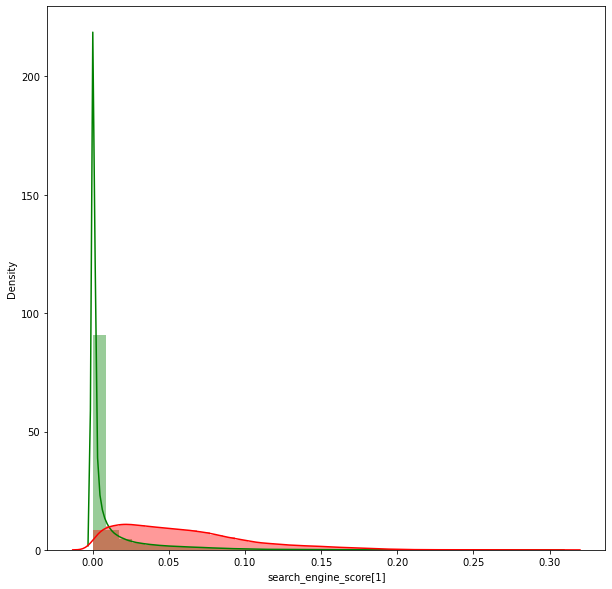

In [51]:
plt.figure(figsize=(10, 10))
sns.distplot(mztab_psms_targets.loc[:, 'search_engine_score[1]'], hist=True, kde=True, 
             bins=int(180/5), color='green')
sns.distplot(mztab_psms_decoys.loc[:, 'search_engine_score[1]'], hist=True, kde=True,
             bins=int(180/5), color = 'red')

<AxesSubplot:>

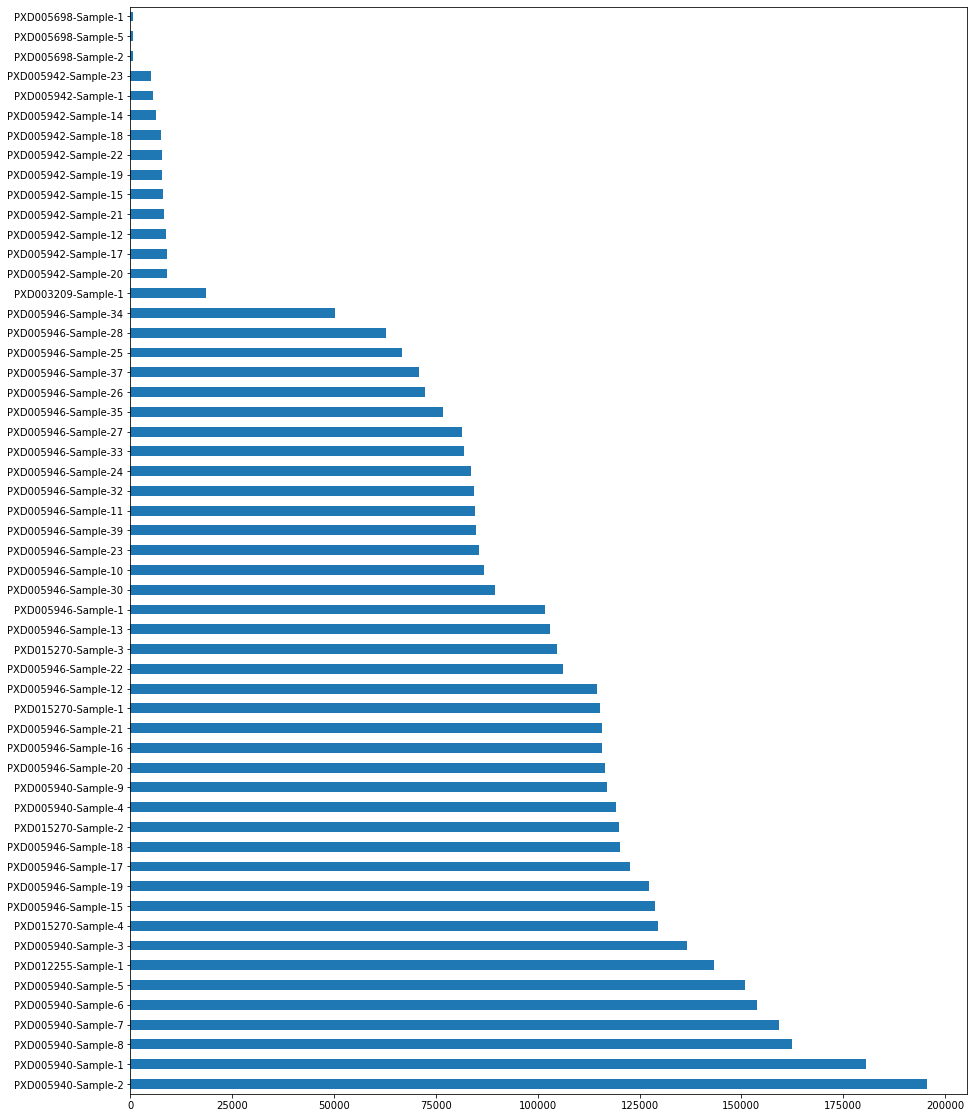

In [52]:
# Print the number of psms per Sample
plt.rcParams["figure.figsize"] = [15, 20]
mztab_psms_targets.Sample.value_counts().plot.barh()

In [53]:
conditions = [(mztab_psms_targets['accession'].str.contains("ENSP") & ~mztab_psms_targets['accession'].str.contains(conatm_ids)),
        (~(mztab_psms_targets['accession'].str.contains("ENSP")|mztab_psms_targets['accession'].str.contains(conatm_ids))
         & mztab_psms_targets['accession'].str.contains(r"altorf|pseudo|ncRNA")),
        (~(mztab_psms_targets['accession'].str.contains(r"ENSP|altorf|pseudo|ncRNA") | mztab_psms_targets['accession'].str.contains(conatm_ids))
         & mztab_psms_targets['accession'].str.contains(r"COSMIC|cbiomut")),
        (mztab_psms_targets['accession'].str.contains(conatm_ids))
             ]
classes = ['canonical', 'non_canonical', 'variant','contaminant']
mztab_psms_targets['Class'] = np.select(conditions, classes)
mztab_psms_targets['Class'].value_counts()

/Users/husen/anaconda3/envs/pgatk/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


canonical        4260065
contaminant       201217
non_canonical      65151
variant              700
Name: Class, dtype: int64

In [54]:
mztab_psms_targets.to_csv('all_'+mzTab_file_name, sep='\t', index=False)

In [55]:
mztab_psms_noncan_targets = mztab_psms_targets[mztab_psms_targets['Class'].str.contains(r"variant|non_canonical")==True]
mztab_noncan_seqs = list(set([rep(x) for x in mztab_psms_noncan_targets['sequence'].tolist()]))

In [56]:
#get non-canonical peptides that are found in canonical proteins
mztab_found_peps = []
auto = ahocorasick.Automaton()
for noncan_seq in mztab_noncan_seqs:
    auto.add_word(noncan_seq, noncan_seq)
auto.make_automaton()
for canseq in allcan_seqs:
    for end_ind, found in auto.iter(canseq):
        mztab_found_peps.append(found)

In [57]:
mztab_psms_noncan_targets = mztab_psms_noncan_targets[mztab_psms_noncan_targets['sequence'].apply(rep).isin(mztab_found_peps)==False]

<AxesSubplot:xlabel='Sample'>

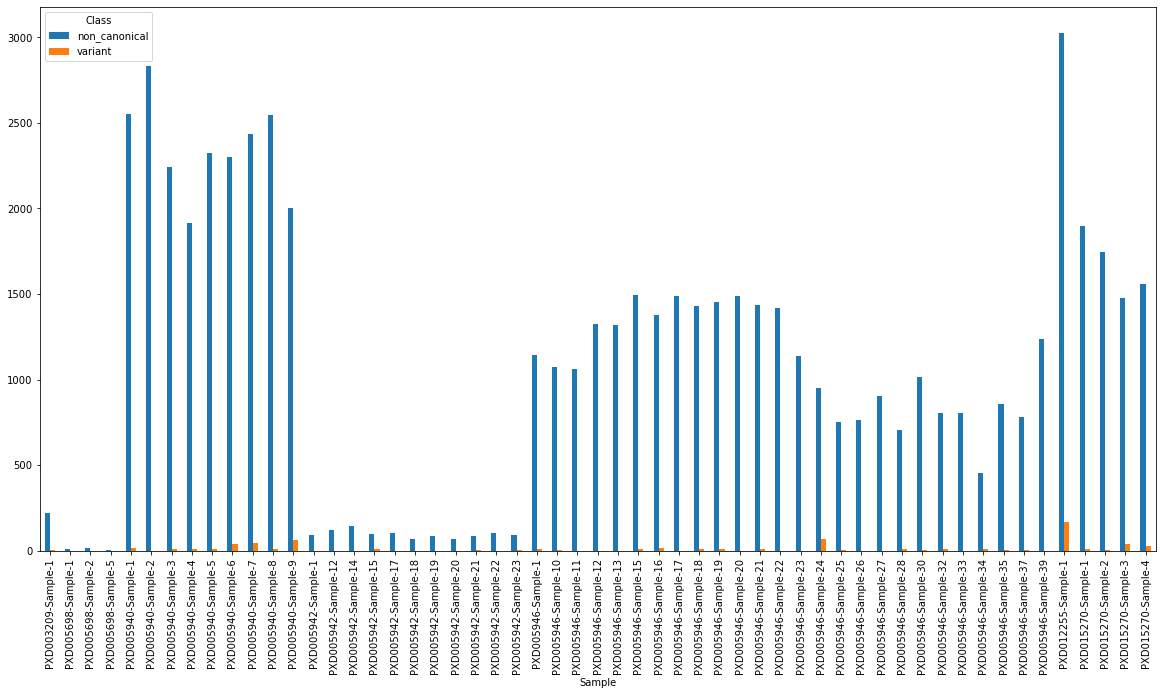

In [82]:
plt.rcParams["figure.figsize"] = [20, 10]
mztab_psms_noncan_targets.groupby('Class').Sample.value_counts().unstack(0).plot.bar()

In [101]:
t1=set(mztab_psms_noncan_targets.sequence.apply(rep).tolist())
t2=set(triqler_noncan_targets.peptide.apply(rep).tolist())
inmzTab_notinTriqler = t1-t2
inTriqler_notinmzTab = t2-t1
print('#sequences in mzTab not in triqler {}'.format(len(inmzTab_notinTriqler)))
print('#sequences in triqler not in mzTab {}'.format(len(inTriqler_notinmzTab)))
print('\n')
print('#unique variant peptides:', len(set(mztab_psms_noncan_targets[mztab_psms_noncan_targets['Class']=='variant']['sequence'].tolist())))
print('#unique non_canonical peptides:', len(set(mztab_psms_noncan_targets[mztab_psms_noncan_targets['Class']=='non_canonical']['sequence'].tolist())))

#sequences in mzTab not in triqler 9297
#sequences in triqler not in mzTab 0


#unique variant peptides: 278
#unique non_canonical peptides: 27342


In [134]:
#search for occurence in public repositories ()
def count_observations(data_proxi) -> int:
  count = 0
  if len(data_proxi) > 0:
    for key in data_proxi:
      count = count + int(key['countPSM'])
  return count

def get_counts(seq):
    #PGMDB
    gpmdb_response = requests.get('http://rest.thegpm.org/1/peptide/count/seq={}'.format(seq))
    gpmdb_data = gpmdb_response.json()
    gpmdb_count = gpmdb_data[0]
    
    #MASSIVE
    massive_url = 'http://massive.ucsd.edu/ProteoSAFe/proxi/v0.1/peptidoforms?resultType=compact&peptideSequence={}'.format(seq)
    massive_result = requests.get(massive_url)
    massive_count = 0
    if massive_result.status_code == 200:
      massive_count = count_observations(massive_result.json())
    
    #PeptideAtlas
    peptideAtlas_url = 'http://www.peptideatlas.org/api/proxi/v0.1/peptidoforms?resultType=compact&peptideSequence={}'.format(seq)
    peptideAtlas_count = count_observations(requests.get(peptideAtlas_url).json())
    
    return [gpmdb_count, massive_count, peptideAtlas_count]

In [ ]:
seqs_counts = {}
for x in set(mztab_psms_noncan_targets.sequence.tolist()):
    seqs_counts[x] = [] 
    
for seq in seqs_counts.keys():
    counts = get_counts(seq)
    counts.append(sum(counts))
    counts.append(seq)
    seqs_counts[seq] = counts

In [ ]:
counts_df = pd.DataFrame.from_dict(seqs_counts, orient = 'index', columns = ['pgmdb', 'massive', 'peptideAtals', 'sum_counts', 'sequence'])
pd.merge(mztab_psms_noncan_targets, counts_df, on='sequence')